# Imports

In [467]:
!pip install causalml

In [468]:
from causalml.inference.meta import BaseRClassifier, BaseSClassifier, BaseTClassifier, BaseXClassifier
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier

from causalml.dataset import synthetic_data
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor

from causalml.dataset.regression import synthetic_data
from causalml.inference.tf import DragonNet
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset.regression import *
from causalml.metrics import *

In [469]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import time
import os
import warnings

from seaborn import diverging_palette

In [470]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from causalml.inference.meta import BaseSRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [471]:
import gc
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%matplotlib inline

In [472]:
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

font = {'family' : 'Optima',
        'weight' : 'regular',
        'size'   : 16}
plt.rc('font', **font)
plt.rc('xtick', labelsize=15)     # tick labels bigger
plt.rc('ytick', labelsize=15)     # tick labels bigger
plt.rc('savefig', dpi=300)       # higher res outputs

# Data acquisition

In [473]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Datasets/customer_retention_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset can be download from Kaggle, you need to login
https://www.kaggle.com/datasets/davinwijaya/customer-retention/data

### 2.2 Check the types

In [474]:
df.dtypes

recency            int64
history          float64
used_discount      int64
used_bogo          int64
zip_code          object
is_referral        int64
channel           object
offer             object
conversion         int64
dtype: object

In [475]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


## 2.3 Profile data using pandas_profiling

In [476]:
! pip install pandas-profiling

In [477]:
! pip install ydata-profiling

In [478]:
import ydata_profiling
ydata_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 2.4 Check the dimensions

In [479]:
df.shape

(64000, 9)

## 2.5 Check the column names

In [480]:
df.columns

Index(['recency', 'history', 'used_discount', 'used_bogo', 'zip_code',
       'is_referral', 'channel', 'offer', 'conversion'],
      dtype='object')

# Data exploration

In [481]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


## 3.1 Provide descriptive statistics

In [482]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


## 3.2 Check data dictionary to understand data
Data dictionary provided at Kaggle which describes the features.

In [483]:
! pip install openpyxl

In [484]:
df_description = pd.read_excel('/content/drive/MyDrive/Datasets/customer-retention-data-dictionary.xlsx').dropna()
df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})

,MarketingCampaignFeature,Description
0,recency,months since last purchase
1,history,$value of the historical purchases
2,used_discount,indicates if the customer used a discount before
3,used_bogo,indicates if the customer used a buy one get one before
4,zip_code,class of the zip code as Suburban/Urban/Rural
5,is_referral,indicates if the customer was acquired from referral channel
6,channel,"channels that the customer using, Phone/Web/Multichannel"
7,offer,"the offers sent to the customers, Discount/But One Get One/No Offer"
8,conversion,customer conversion(buy or not)


## 3.3 Check the distribution of used_discount

In [485]:
df['used_discount'].value_counts()

1    35266
0    28734
Name: used_discount, dtype: int64

## 3.4 Check the distribution of used_bogo

In [486]:
df['used_bogo'].value_counts()

1    35182
0    28818
Name: used_bogo, dtype: int64

## 3.5 Check the distribution of zip_code

In [487]:
df['zip_code'].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

## 3.6 Check the distribution of is_referral

In [488]:
df['is_referral'].value_counts()

1    32144
0    31856
Name: is_referral, dtype: int64

## 3.7 Check the distribution of channel

In [489]:
df['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

## 3.8 Check the distribution of offer

In [490]:
df['offer'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64

# Dealing with missing values and duplicates

## 4.1 Check missing values

In [491]:
def missing_values(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)
    print("Dataframe has " + str(df.shape[1]) + " columns.")
    print("There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    return mis_val_table_ren_columns

In [492]:
# Missing values statistics
miss_values = missing_values(df)
miss_values.head(20)

Dataframe has 9 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## 4.2 Check duplicate observations

In [493]:
duplicate_rows = df[df.duplicated()]

print(duplicate_rows.shape)

(6603, 9)


## 4.3 Remove duplicates

In [494]:
df = df.drop_duplicates()

df.shape

(57397, 9)

# Target

## 5.1 Check the distribution of target

In [495]:
df['conversion'].value_counts()

0    48436
1     8961
Name: conversion, dtype: int64

## 5.2 Handle with imbalanced class

In [496]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df['conversion'] == 0]
df_minority = df[df['conversion'] == 1]

In [497]:
# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
df = pd.concat([df_majority, df_minority_upsampled])

print(df.shape)

(96872, 9)


## 5.3 Check the new distribution of target

In [498]:
df['conversion'].value_counts()

0    48436
1    48436
Name: conversion, dtype: int64

# Data Exploration

## 6.1 Correlations
Check top 10 positive and negative correlations

In [499]:
# Ensure only numeric columns are included in the correlation calculation
numeric_df = df.select_dtypes(include=[np.number])

# Calculate correlations with the target variable
corr = numeric_df.corr()['conversion'].sort_values()

# Display correlations
print('Top 10 - Positive Correlations:')
print('-----------------------------------')
print(corr.tail(10))
print('\nTop 10 - Negative Correlations:')
print('------------------------------')
print(corr.head(10))

Top 10 - Positive Correlations:
-----------------------------------
is_referral     -0.098283
recency         -0.096802
used_discount    0.011271
history          0.062142
used_bogo        0.068273
conversion       1.000000
Name: conversion, dtype: float64

Top 10 - Negative Correlations:
------------------------------
is_referral     -0.098283
recency         -0.096802
used_discount    0.011271
history          0.062142
used_bogo        0.068273
conversion       1.000000
Name: conversion, dtype: float64


[Text(0.5, 0, 'recency'),
 Text(1.5, 0, 'history'),
 Text(2.5, 0, 'used_discount'),
 Text(3.5, 0, 'used_bogo'),
 Text(4.5, 0, 'is_referral'),
 Text(5.5, 0, 'conversion')]

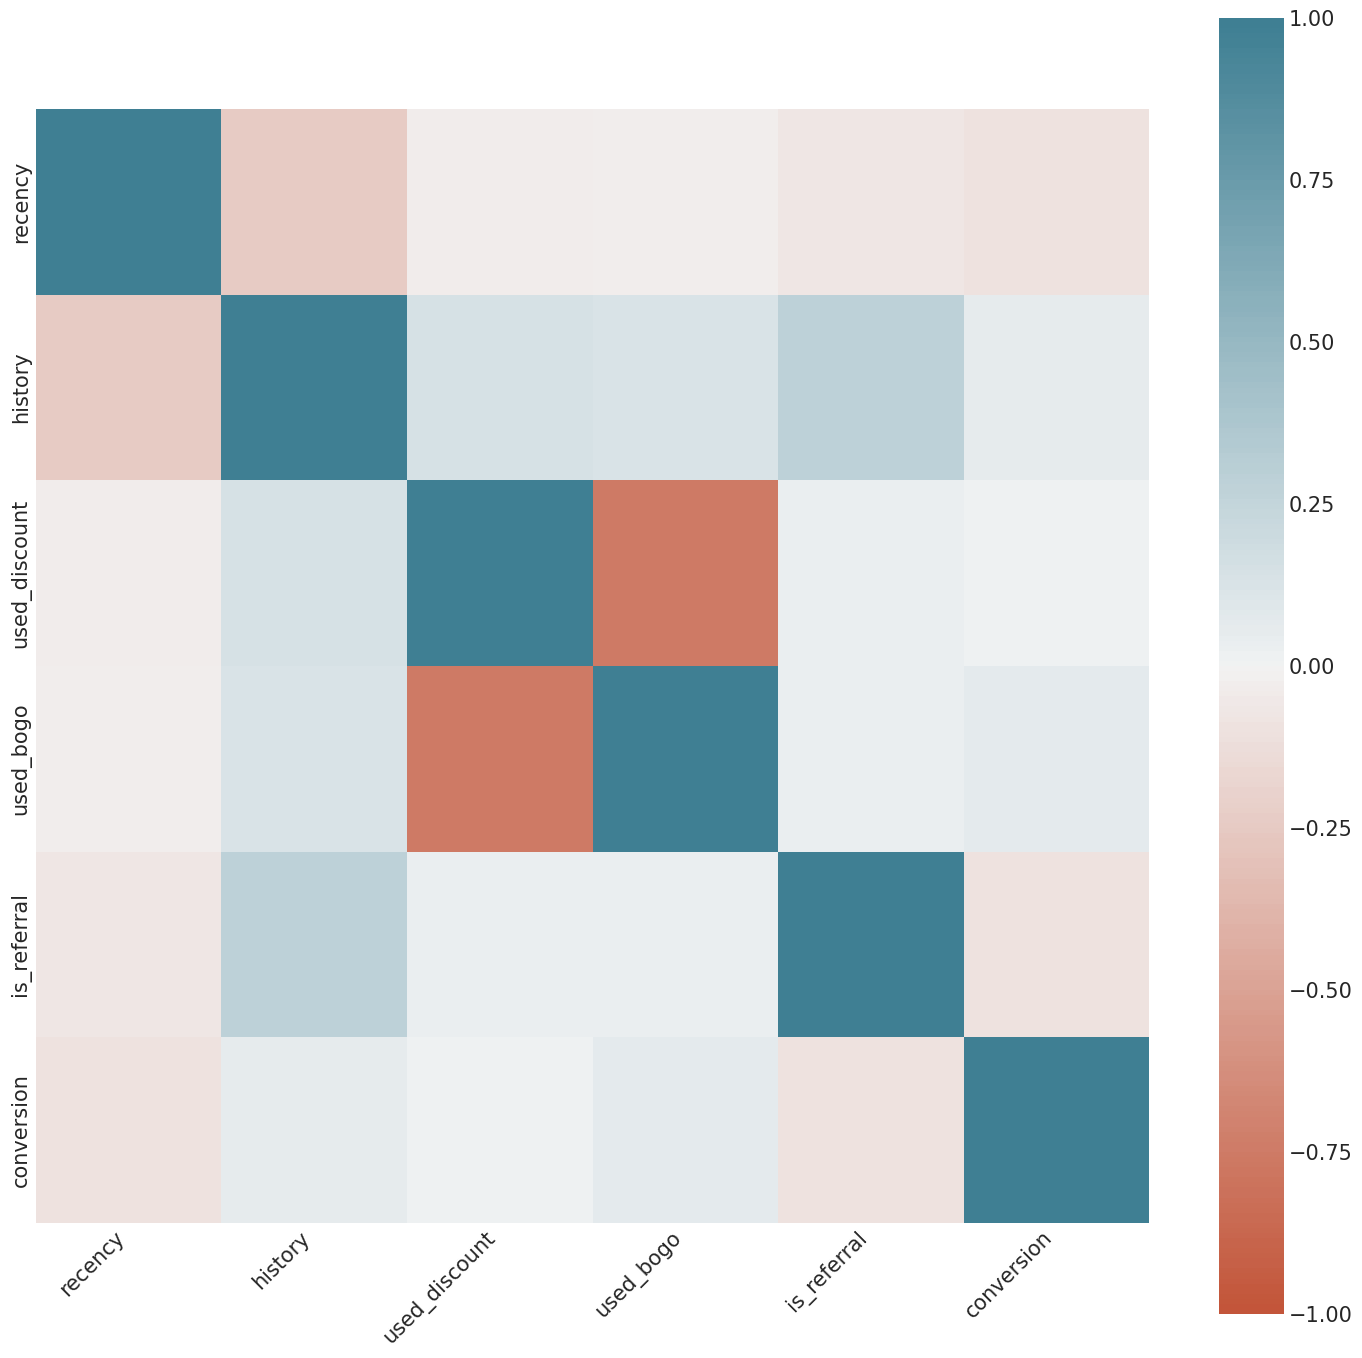

In [500]:
correlation = numeric_df.corr()
plt.figure(figsize=(16, 16))
ax = sns.heatmap(
    correlation,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

## 6.2 Convert three catgeory channel to two category

In [501]:
replacement = {'Discount': 'Offer', 'Buy One Get One': 'Offer'}

df['offer'].replace(replacement, inplace=True)

# Categorical encodings

## 7.1 Label encode categorical features

In [502]:
df['offer'] = df['offer'].replace({'Offer': 1, 'No Offer': 0})

## 7.2 One-hot encoding the rest of categorical columns

In [503]:
# Create dummy variables for the specified columns
df = pd.get_dummies(df)

print(df.shape)

(96872, 13)


## 7.3 View the encoded dataset

In [504]:
df.head()

,recency,history,used_discount,used_bogo,is_referral,offer,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,1,0,0,1,0,0,0,1
3,9,675.83,1,0,1,1,0,1,0,0,0,0,1
4,2,45.34,1,0,0,1,0,0,0,1,0,0,1


In [505]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96872 entries, 0 to 21999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recency               96872 non-null  int64  
 1   history               96872 non-null  float64
 2   used_discount         96872 non-null  int64  
 3   used_bogo             96872 non-null  int64  
 4   is_referral           96872 non-null  int64  
 5   offer                 96872 non-null  int64  
 6   conversion            96872 non-null  int64  
 7   zip_code_Rural        96872 non-null  uint8  
 8   zip_code_Surburban    96872 non-null  uint8  
 9   zip_code_Urban        96872 non-null  uint8  
 10  channel_Multichannel  96872 non-null  uint8  
 11  channel_Phone         96872 non-null  uint8  
 12  channel_Web           96872 non-null  uint8  
dtypes: float64(1), int64(6), uint8(6)
memory usage: 6.5 MB


## 7.4 Convert all column names of df to lowercase

In [506]:
df.columns = df.columns.str.lower()

## 7.5 Convert specified columns to int64 data type

In [507]:
columns_to_convert = ['history', 'zip_code_rural', 'zip_code_surburban', 'zip_code_urban', 'channel_multichannel',
                      'channel_phone', 'channel_web']

df[columns_to_convert] = df[columns_to_convert].astype(int)

# Seperate features, treatment and target

In [508]:
X = df.loc[:, ~df.columns.isin(['conversion', 'offer'])]
y = df['conversion']
treatment = df['offer']

In [509]:
feature_names = X.columns
print(feature_names)

Index(['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
       'zip_code_rural', 'zip_code_surburban', 'zip_code_urban',
       'channel_multichannel', 'channel_phone', 'channel_web'],
      dtype='object')


## 8.1 Look at the conversion rate and sample size in each group

In [510]:
df.pivot_table(values='conversion',
               index='offer',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,conversion,conversion
offer,,
0,0.412622,28743
1,0.536864,68129
All,0.500000,96872


# XGBClassifier: S-Learner
BaseSClassifier and XGBClassifier

In [511]:
# Meta-learner uplift models
from causalml.inference.meta import BaseSClassifier

# Machine learning algorithms
from xgboost import XGBClassifier

## S-Learner Average Treatment Effect (ATE)

To estimate the average treatment effect (ATE) using BaseSClassifier, we first initiate the BaseSClassifier, then get the average treatment effect (ATE) and its upper bound and lower bound using the estimate_ate method. \

Besides passing in the covariates, the treatment variable, and the outcome variable, we need to specify return_ci=True to get the confidence interval for the estimated average treatment effect (ATE). \

We can see that the estimated average treatment effect (ATE) is 0.14.

In [512]:
# Use XGBClassifier with BaseSClassifier
xg_slearner = BaseSClassifier(XGBClassifier(random_state=42))

# Estimate ATE, upper bound, and lower bound
ate, lb, ub = xg_slearner.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True)

# Print out results
print('Average Treatment Effect for treatment: {:.2f} ({:.2f}, {:2f})'.format(ate[0], lb[0], ub[0]))

Average Treatment Effect for treatment: 0.14 (0.13, 0.141034)


## S-Learner Individual Treatment Effect (ITE)

Now we will use the s-learner to estimate the individual treatment effect (ITE). \

The method fit_predict produces the estimated individual treatment effect (ITE). \

From the first five results, we can see that the treatment has a positive impact on some individuals and a negative impact on some other indiviudals.

In [513]:
# ITE
xg_slearner_ite = xg_slearner.fit_predict(X, treatment, y)

# Take a look at the data
np.matrix(xg_slearner_ite[:5])

matrix([[0.20525695],
        [0.05489504],
        [0.1281957 ],
        [0.04861072],
        [0.21488377]])

In [514]:
# Print out estimation for one record
print(f'The estimated ITE for treatment for the second record : {xg_slearner_ite[1][0]:.2f}')
print(f'The estimated ITE for treatment for the third record : {xg_slearner_ite[2][0]:.2f}')

The estimated ITE for treatment for the second record : 0.05
The estimated ITE for treatment for the third record : 0.13


We can take the mean of the estimated individual treatment effect (ITE) to get the average treatment effect (ATE). We can see that the average treatment effect (ATE) value of 0.14 is the same as what we estimated using the estimate_ate method.

In [515]:
# Estimate ATE
xg_slearner_ite.mean()

0.1351556494067422

## S-Learner Model Feature Importance

Now we will check the s-learner feature importance. \

The python causalML package provides two methods for calculating feature importance.
- auto works on a tree-based estimator. It uses the estimator's default feature importance. If no tree-based estimator is provided, it falls back to the LGBRegressor and gain as the importance type.
- permutation works on any estimator. It permutes a feature column and calculates the decrease in accuracy. The feature importance is ordered based on the magnitude of the decrease in accuracy. When the sample size is large, downsampling is suggested. \

Both methods are based on a machine learning model, where the dependent variable is the individual treatment effect (ITE) and the independent variables are the features of the model.
- get_importance is the function to get the feature importance values.
- x takes in the feature matrix.
- tau takes in the individual treatment effect (ITE).
- normalize=True normalizes the importance value by the sum of importance. It only works for method=' auto' .
- features=feature_names prints out the feature names in the outputs.
- method specifies whether to use auto or permutation for the feature importance calculation.

### Feature importance using auto

In [516]:
xg_slearner.get_importance(X=X, tau=xg_slearner_ite, normalize=True, method='auto', features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: history                 0.463016
 recency                 0.183917
 used_bogo               0.128657
 is_referral             0.091174
 zip_code_rural          0.044181
 used_discount           0.029806
 channel_phone           0.019047
 channel_web             0.013338
 zip_code_surburban      0.011618
 channel_multichannel    0.008016
 zip_code_urban          0.007229
 dtype: float64}

From the method= 'auto' output, we can see that **history** is the most important feature, and **zip_code_urban** is the least important feature. \

All the importance values add up to 1 because we specified normalize=True. \

We can also visualize the feature importance using the plot_importance function.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

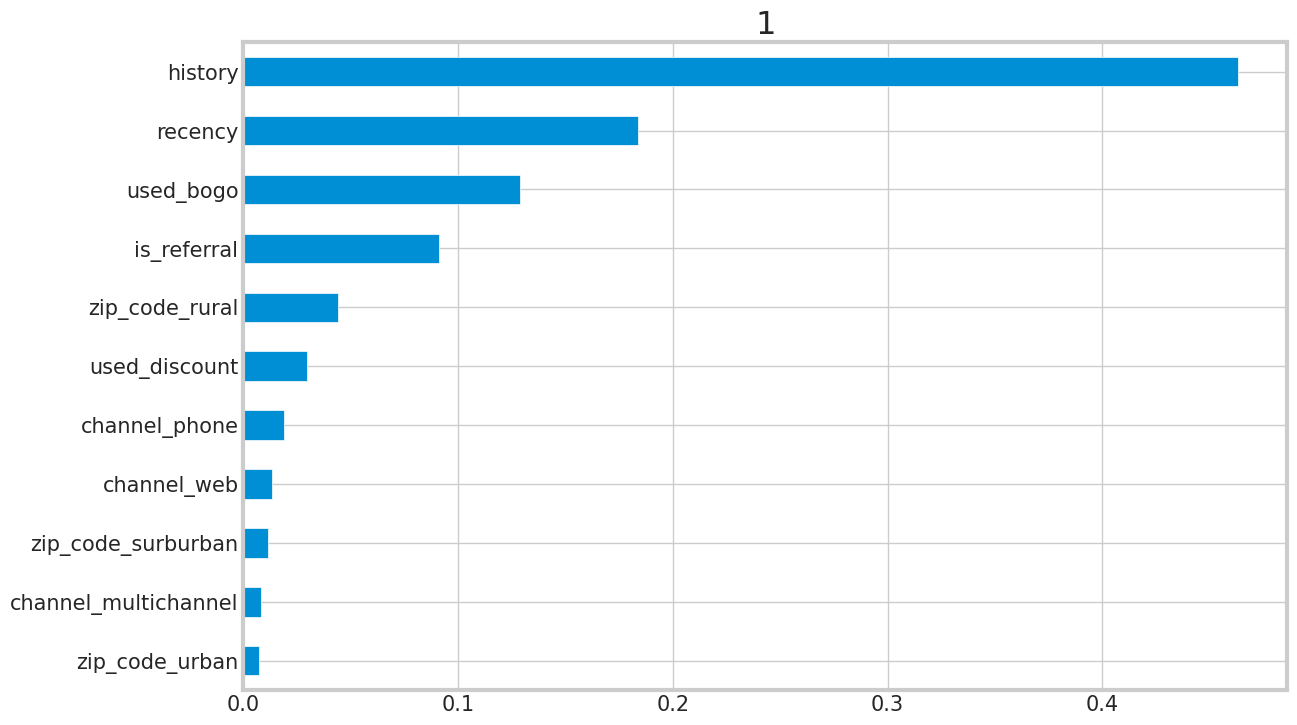

In [517]:
# Visualization
xg_slearner.plot_importance(X=X, tau=xg_slearner_ite, normalize=True, method='auto', features=feature_names)

### Feature importance using permutation

When calculating the feature importance using the permutation method, we need to add a random_state number to make the results reproducible.

In [518]:
xg_slearner.get_importance(X=X, tau=xg_slearner_ite, normalize=True, method='permutation', features=feature_names,
                           random_state=42)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: history                 0.684481
 recency                 0.380885
 used_bogo               0.351523
 is_referral             0.222984
 zip_code_rural          0.078964
 used_discount           0.069227
 channel_phone           0.037877
 channel_web             0.036985
 zip_code_surburban      0.017294
 zip_code_urban          0.009099
 channel_multichannel    0.007222
 dtype: float64}

From the method='permutation' output, we can see that **history** is the most importance feature, and **channel_multichannel** is the least important feature. This is similar to the auto method results. \

We can also visualize the feature importance using the plot_ importance function.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

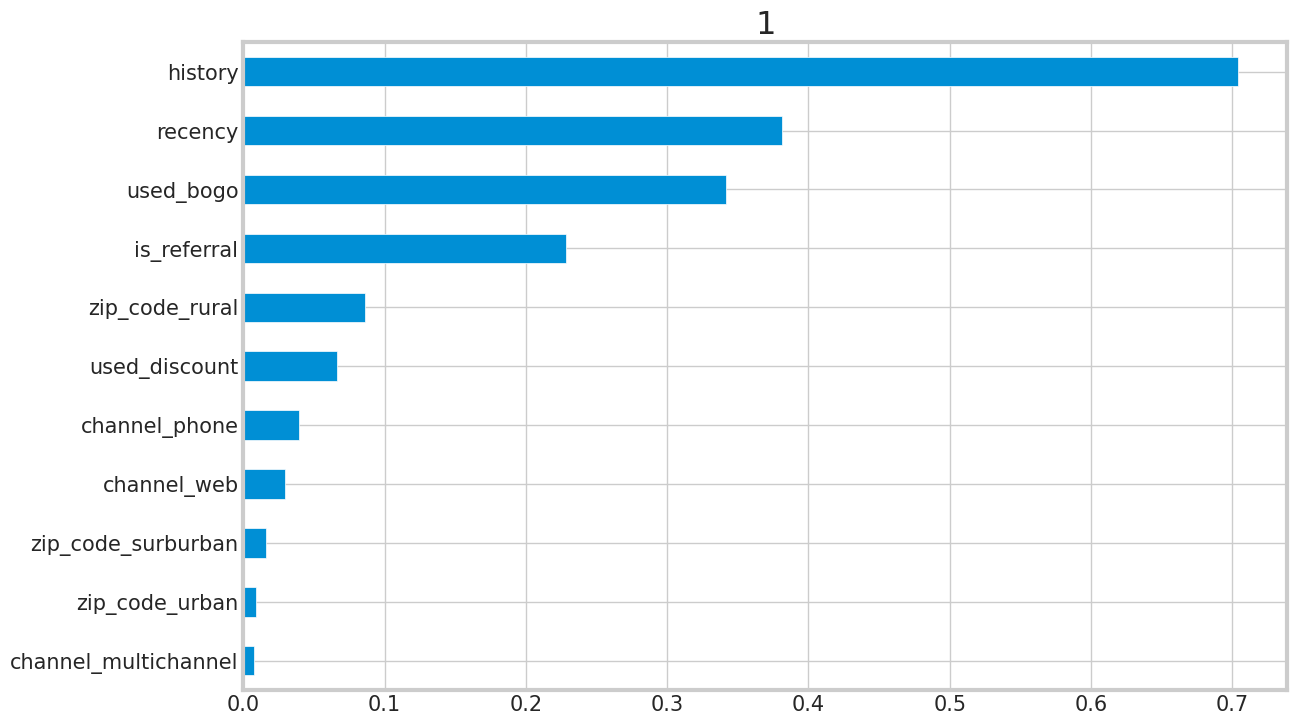

In [519]:
# Visualization
xg_slearner.plot_importance(X=X, tau=xg_slearner_ite, normalize=True, method='permutation', features=feature_names)

## S-Learner Model Interpretation

Now we will interpret the s-learner model using SHAP (SHapley Additive exPlanations).

The sharpley values are calculated based on a machine learning model, where the dependent variable is the individual treatment effect (ITE) and the independent variables are the features of the model.
- plot_shap_values is the function to visualize SHAP values.
- X takes in the feature matrix.
- tau takes in the individual treatment effect (ITE).
- features=feature_names prints out the feature names in the outputs.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

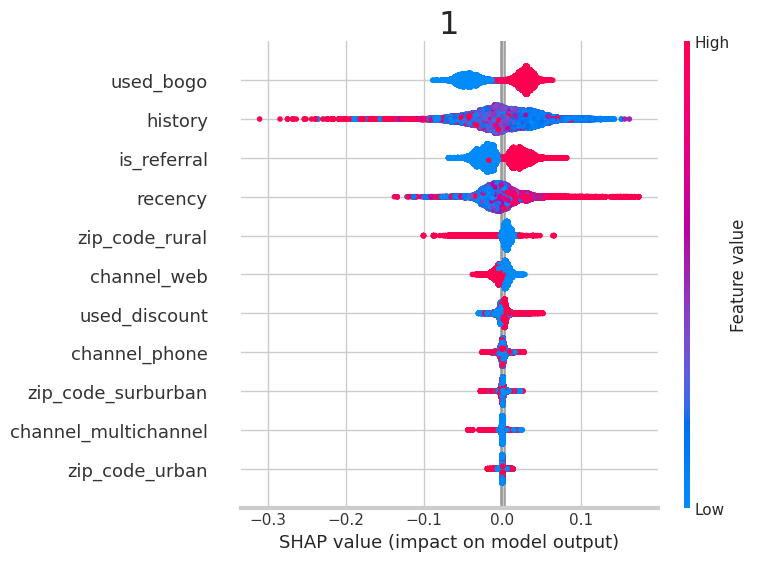

In [520]:
# Plot shap values
xg_slearner.plot_shap_values(X=X, tau=xg_slearner_ite, features=feature_names)

The SHAP plot includes both the feature importance and the feature impacts.
- The y-axis is the list of features ordered from the most important to the least important.
- The x-axis is the SHAP value, representing how each feature impacts the model output.
- The color of the dots represents the feature values. Blue indicates low values, and red indicates high values.
- The overlapping dots are jittered, which helps us to see the distribution of each feature. \

For example, from the SHAP plot we can see that
- **used_bogo** is the most important feature, followed by **history**, **is_referral**, and **recency**.
- Higher value of **used_bogo** (customer used a buy one get one before) leads to higher chance of conversion. Lower value of **used_bogo** (customer has not used a buy one get one before) leads to lower chance of conversion.

# XGBClassifier: T-Learner
BaseTClassifier and XGBClassifier

In [521]:
# Meta-learner uplift models
from causalml.inference.meta import BaseTClassifier

## T-Learner Average Treatment Effect (ATE)

In [522]:
# Use XGBClassifier with BaseTClassifier
xg_tlearner = BaseTClassifier(XGBClassifier(random_state=42))

# Estimate ATE, upper bound, and lower bound
ate, lb, ub = xg_tlearner.estimate_ate(X=X, treatment=treatment, y=y)

# Print out results
print('Average Treatment Effect for treatment: {:.2f} ({:.2f}, {:2f})'.format(ate[0], lb[0], ub[0]))

Average Treatment Effect for treatment: 0.17 (0.16, 0.175972)


## T-Learner Individual Treatment Effect (ITE)

In [523]:
# ITE
xg_tlearner_ite = xg_tlearner.fit_predict(X, treatment, y)

# Take a look at the data
np.matrix(xg_tlearner_ite[:5])

matrix([[0.21345511],
        [0.07970691],
        [0.06196478],
        [0.01045302],
        [0.41883793]])

In [524]:
# Print out estimation for one record
print(f'The estimated ITE for treatment for the second record : {xg_tlearner_ite[1][0]:.2f}')
print(f'The estimated ITE for treatment for the third record : {xg_tlearner_ite[2][0]:.2f}')

The estimated ITE for treatment for the second record : 0.08
The estimated ITE for treatment for the third record : 0.06


## T-Learner Model Feature Importance

### Feature importance using auto

In [525]:
xg_tlearner.get_importance(X=X, tau=xg_tlearner_ite, normalize=True, method='auto', features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: history                 0.506229
 recency                 0.191972
 used_bogo               0.057887
 is_referral             0.051988
 zip_code_surburban      0.037864
 used_discount           0.033678
 channel_phone           0.030076
 zip_code_rural          0.028133
 channel_web             0.026811
 zip_code_urban          0.019663
 channel_multichannel    0.015698
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

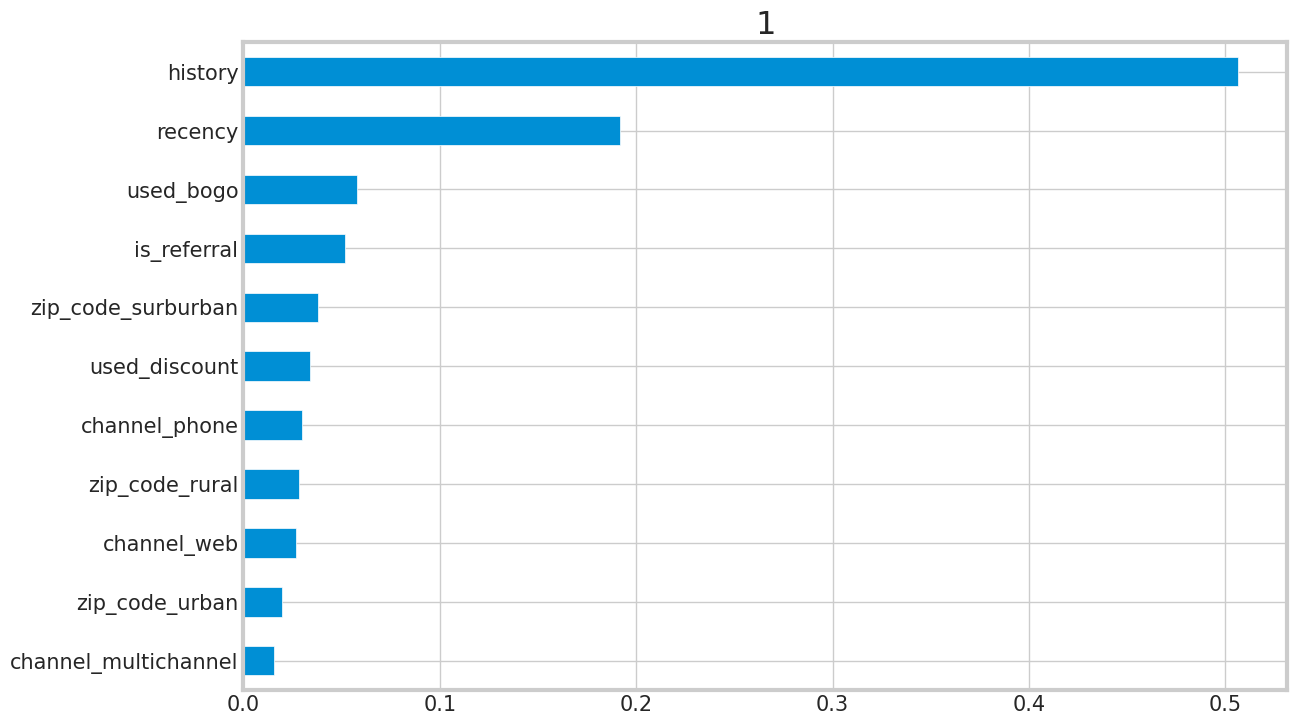

In [526]:
# Visualization
xg_tlearner.plot_importance(X=X, tau=xg_tlearner_ite, normalize=True, method='auto', features=feature_names)

### Feature importance using permutation

In [527]:
xg_tlearner.get_importance(X=X, tau=xg_tlearner_ite, normalize=True, method='permutation', features=feature_names,
                           random_state=42)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: history                 0.462301
 recency                 0.282126
 used_bogo               0.135046
 is_referral             0.116258
 used_discount           0.038040
 zip_code_surburban      0.035719
 channel_phone           0.029972
 zip_code_rural          0.029745
 channel_web             0.029375
 zip_code_urban          0.014893
 channel_multichannel    0.012925
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

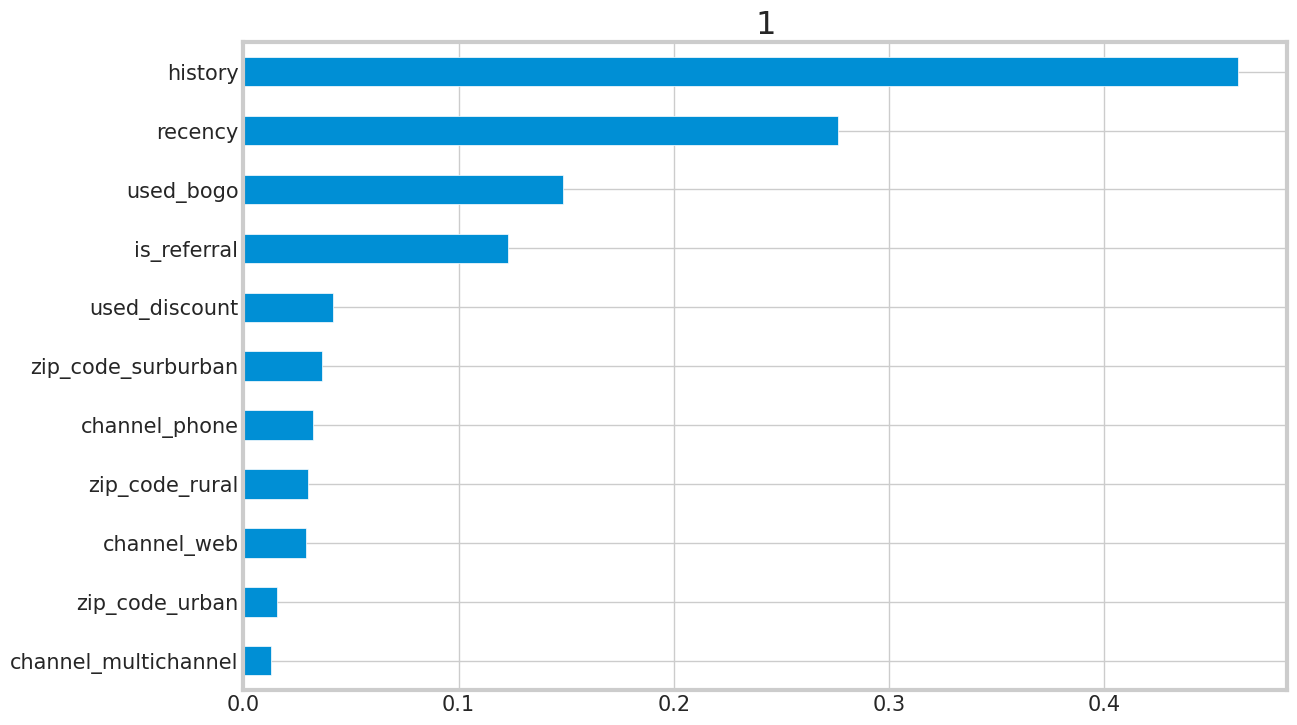

In [528]:
# Visualization
xg_tlearner.plot_importance(X=X, tau=xg_tlearner_ite, normalize=True, method='permutation', features=feature_names)

## T-Learner Model Interpretation

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

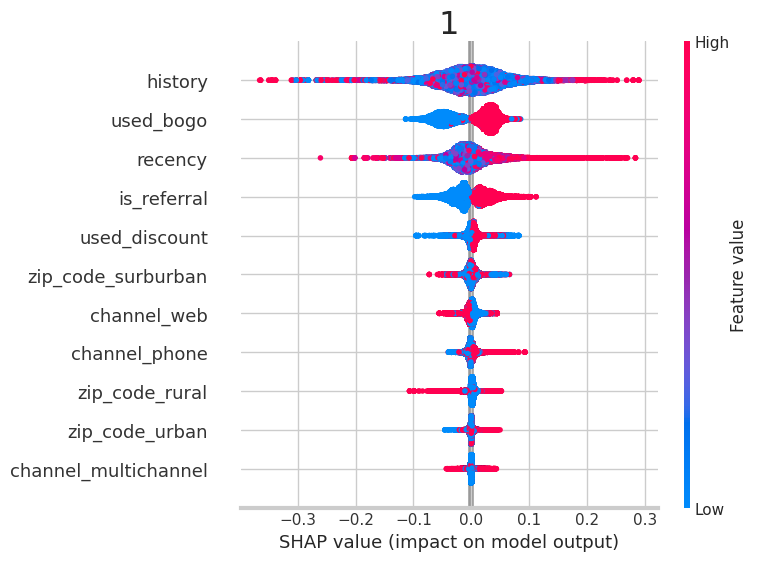

In [529]:
# Plot shap values
xg_tlearner.plot_shap_values(X=X, tau=xg_tlearner_ite, features=feature_names)

From the SHAP plot we can see that
- **history** is the most important feature, followed by **used_bogo**, **recency**, and **is_referral**.
- Higher value of **used_bogo** (customer used a buy one get one before) leads to higher chance of conversion. Lower value of **used_bogo** (customer has not used a buy one get one before) leads to lower chance of conversion.

In [530]:
xg_slearner_predictions = xg_slearner.predict(X)
xg_tlearner_predictions = xg_tlearner.predict(X)

df_preds = pd.DataFrame([xg_slearner_predictions.ravel(),
                          xg_tlearner_predictions.ravel(),
                          treatment.ravel(),
                          y.ravel()],
                       index=['S','T','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [531]:
df_result = pd.DataFrame([xg_slearner, xg_tlearner],
                     index=['S','T'], columns=['ATE'])
df_result['AUUC'] = auuc_score(df_preds)

In [532]:
df_result

,ATE,AUUC
S,BaseSClassifier(model=XGBClassifier(base_score...,1.123862
T,BaseTClassifier(model_c=XGBClassifier(base_sco...,1.695161


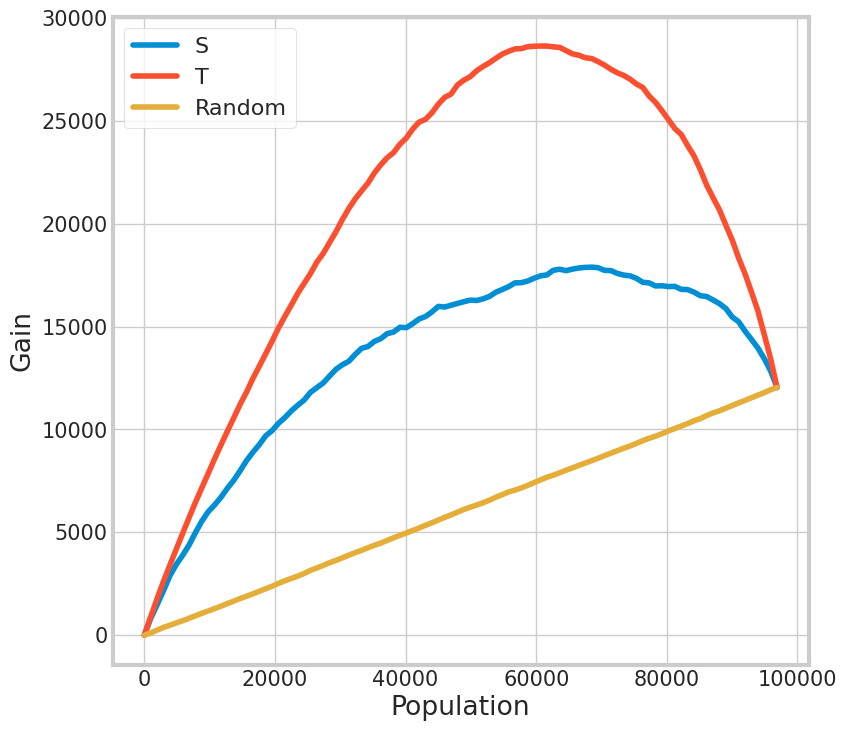

In [533]:
plot_gain(df_preds)

# LGBMClassifier: S-Learner
BaseSClassifier and LGBMClassifier

In [534]:
# Machine learning algorithms
from lightgbm import LGBMClassifier

## S-Learner Average Treatment Effect (ATE)

In [535]:
# Use LGBMClassifier with BaseSClassifier
lg_slearner = BaseSClassifier(LGBMClassifier(random_state=42))

# Estimate ATE, upper bound, and lower bound
ate, lb, ub = lg_slearner.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True)

# Print out results
print('Average Treatment Effect for treatment: {:.2f} ({:.2f}, {:2f})'.format(ate[0], lb[0], ub[0]))

[LightGBM] [Info] Number of positive: 48436, number of negative: 48436
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 96872, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Average Treatment Effect for treatment: 0.13 (0.12, 0.133635)


## S-Learner Individual Treatment Effect (ITE)

In [536]:
# ITE
lg_slearner_ite = lg_slearner.fit_predict(X, treatment, y)

# Take a look at the data
np.matrix(lg_slearner_ite[:5])

[LightGBM] [Info] Number of positive: 48436, number of negative: 48436
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 96872, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


matrix([[0.07236552],
        [0.13010829],
        [0.14517868],
        [0.04417739],
        [0.10190066]])

In [537]:
# Print out estimation for one record
print(f'The estimated ITE for treatment for the second record : {lg_slearner_ite[1][0]:.2f}')
print(f'The estimated ITE for treatment for the third record : {lg_slearner_ite[2][0]:.2f}')

The estimated ITE for treatment for the second record : 0.13
The estimated ITE for treatment for the third record : 0.15


## S-Learner Model Feature Importance

### Feature importance using auto

In [538]:
lg_slearner.get_importance(X=X, tau=lg_slearner_ite, normalize=True, method='auto', features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: history                 0.282079
 used_bogo               0.236961
 recency                 0.190632
 is_referral             0.133762
 zip_code_rural          0.057413
 used_discount           0.038890
 channel_phone           0.024790
 channel_web             0.024527
 zip_code_surburban      0.005206
 channel_multichannel    0.003412
 zip_code_urban          0.002329
 dtype: float64}

From the method= 'auto' output, we can see that **history** is the most important feature, and **zip_code_urban** is the least important feature. \

All the importance values add up to 1 because we specified normalize=True. \

We can also visualize the feature importance using the plot_importance function.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

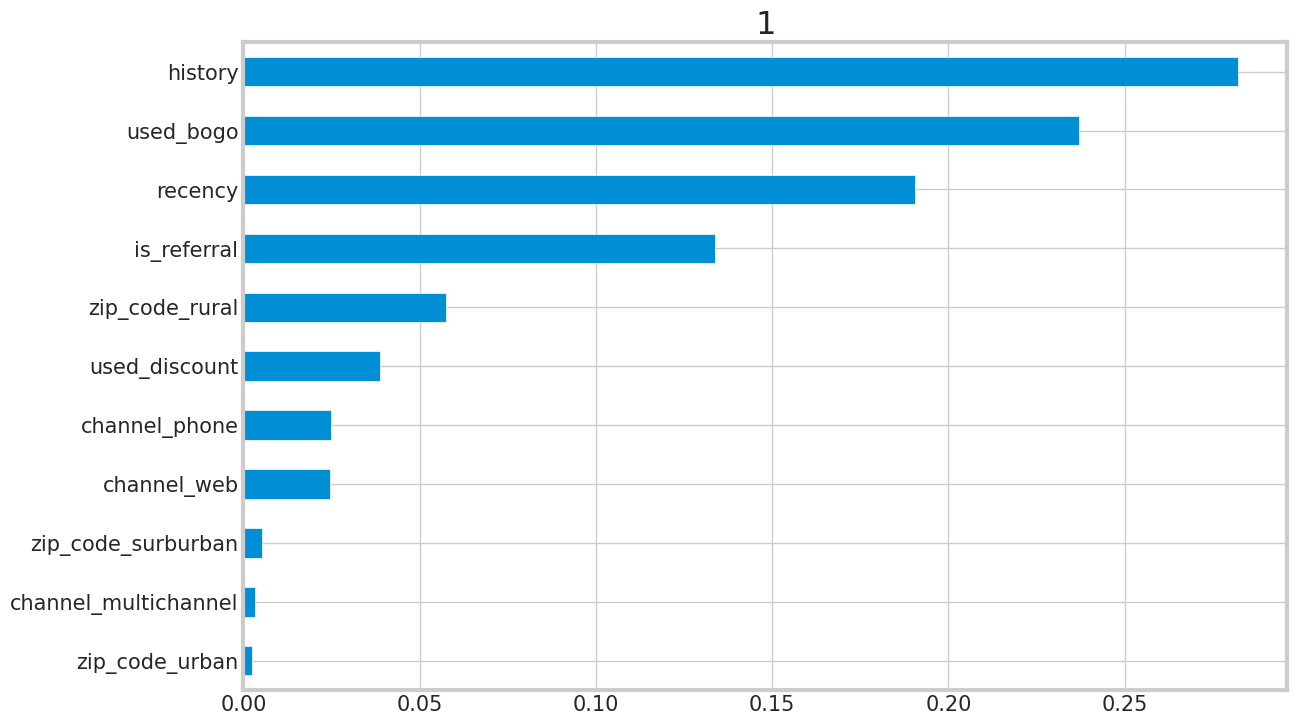

In [539]:
# Visualization
lg_slearner.plot_importance(X=X, tau=lg_slearner_ite, normalize=True, method='auto', features=feature_names)

### Feature importance using permutation

In [540]:
lg_slearner.get_importance(X=X, tau=lg_slearner_ite, normalize=True, method='permutation', features=feature_names,
                           random_state=42)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: used_bogo               0.749722
 history                 0.572514
 recency                 0.501742
 is_referral             0.464599
 used_discount           0.157686
 zip_code_rural          0.137650
 channel_web             0.055304
 channel_phone           0.055027
 zip_code_surburban      0.009356
 channel_multichannel    0.004962
 zip_code_urban          0.001971
 dtype: float64}

From the method='permutation' output, we can see that **used_bogo** is the most importance feature, and **zip_code_urban** is the least important feature. This is different from the auto method results. \

We can also visualize the feature importance using the plot_ importance function.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

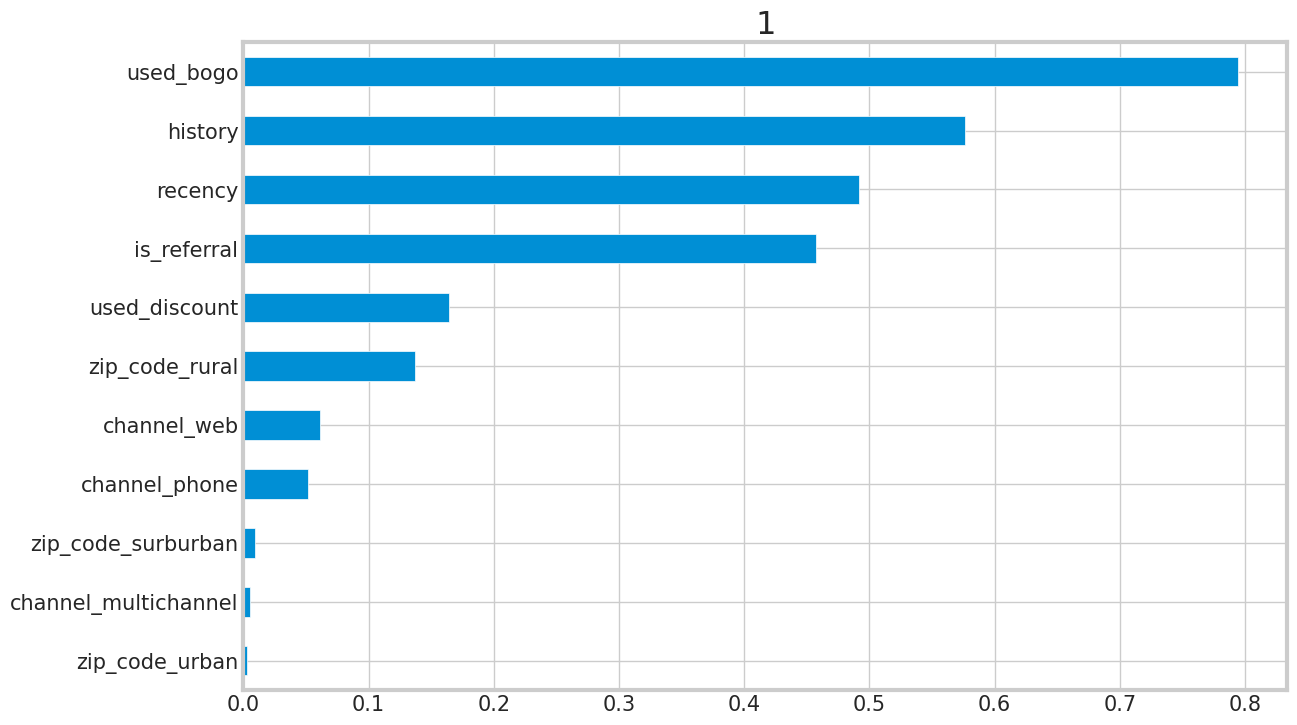

In [541]:
# Visualization
lg_slearner.plot_importance(X=X, tau=lg_slearner_ite, normalize=True, method='permutation', features=feature_names)

## S-Learner Model Interpretation

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

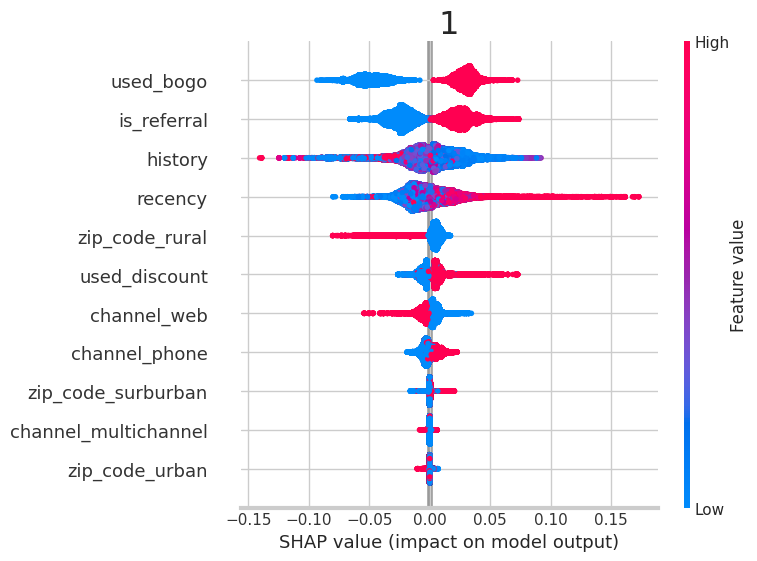

In [542]:
# Plot shap values
lg_slearner.plot_shap_values(X=X, tau=lg_slearner_ite, features=feature_names)

From the SHAP plot we can see that
- **used_bogo** is the most important feature, followed by **is_referral**, **history**, and **recency**.
- Higher value of **used_bogo** (customer used a buy one get one before) leads to higher chance of conversion. Lower value of **used_bogo** (customer has not used a buy one get one before) leads to lower chance of conversion.

# LGBMClassifier: T-Learner
BaseTClassifier and LGBMClassifier

In [543]:
# Machine learning algorithms
from lightgbm import LGBMClassifier

## T-Learner Average Treatment Effect (ATE)

In [544]:
# Use LGBMClassifier with BaseTClassifier
lg_tlearner = BaseTClassifier(LGBMClassifier(random_state=42))

# Estimate ATE, upper bound, and lower bound
ate, lb, ub = lg_tlearner.estimate_ate(X=X, treatment=treatment, y=y)

# Print out results
print('Average Treatment Effect for treatment: {:.2f} ({:.2f}, {:2f})'.format(ate[0], lb[0], ub[0]))

[LightGBM] [Info] Number of positive: 11860, number of negative: 16883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 28743, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.412622 -> initscore=-0.353136
[LightGBM] [Info] Start training from score -0.353136
[LightGBM] [Info] Number of positive: 36576, number of negative: 31553
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 68129, number of used features: 11
[LightGBM] [Info] [b

## T-Learner Individual Treatment Effect (ITE)

In [545]:
# ITE
lg_tlearner_ite = lg_tlearner.fit_predict(X, treatment, y)

# Take a look at the data
np.matrix(lg_tlearner_ite[:5])

[LightGBM] [Info] Number of positive: 11860, number of negative: 16883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 28743, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.412622 -> initscore=-0.353136
[LightGBM] [Info] Start training from score -0.353136
[LightGBM] [Info] Number of positive: 36576, number of negative: 31553
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 68129, number of used features: 11
[LightGBM] [Info] [b

matrix([[0.11063561],
        [0.12621529],
        [0.13574814],
        [0.09714864],
        [0.17807821]])

In [546]:
# Print out estimation for one record
print(f'The estimated ITE for treatment for the second record : {lg_tlearner_ite[1][0]:.2f}')
print(f'The estimated ITE for treatment for the third record : {lg_tlearner_ite[2][0]:.2f}')

The estimated ITE for treatment for the second record : 0.13
The estimated ITE for treatment for the third record : 0.14


## T-Learner Model Feature Importance

### Feature importance using auto

In [547]:
lg_tlearner.get_importance(X=X, tau=lg_tlearner_ite, normalize=True, method='auto', features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: history                 0.411065
 recency                 0.212287
 used_bogo               0.110359
 is_referral             0.088736
 zip_code_rural          0.054881
 used_discount           0.039542
 channel_web             0.025907
 channel_phone           0.023922
 zip_code_surburban      0.016719
 zip_code_urban          0.011122
 channel_multichannel    0.005461
 dtype: float64}

From the method= 'auto' output, we can see that **history** is the most important feature, and **channel_multichannel** is the least important feature. \

All the importance values add up to 1 because we specified normalize=True. \

We can also visualize the feature importance using the plot_importance function.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

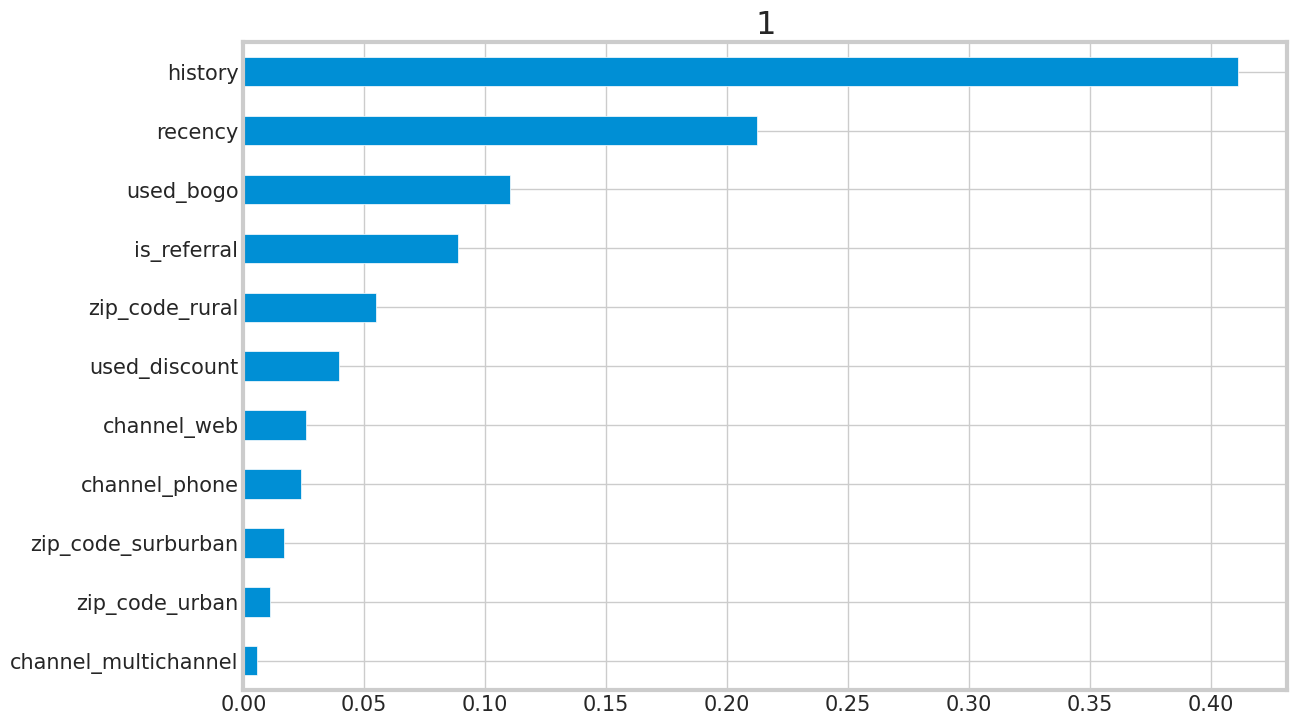

In [548]:
# Visualization
lg_tlearner.plot_importance(X=X, tau=lg_tlearner_ite, normalize=True, method='auto', features=feature_names)

### Feature importance using permutation

In [549]:
lg_tlearner.get_importance(X=X, tau=lg_tlearner_ite, normalize=True, method='permutation', features=feature_names,
                           random_state=42)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: history                 0.600381
 recency                 0.488104
 used_bogo               0.309304
 is_referral             0.290637
 zip_code_rural          0.080858
 used_discount           0.076741
 channel_web             0.054567
 channel_phone           0.051675
 zip_code_surburban      0.019140
 zip_code_urban          0.013302
 channel_multichannel    0.003153
 dtype: float64}

From the method='permutation' output, we can see that **history** is the most importance feature, and **channel_multichannel** is the least important feature. This is similar to the auto method results. \

We can also visualize the feature importance using the plot_ importance function.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

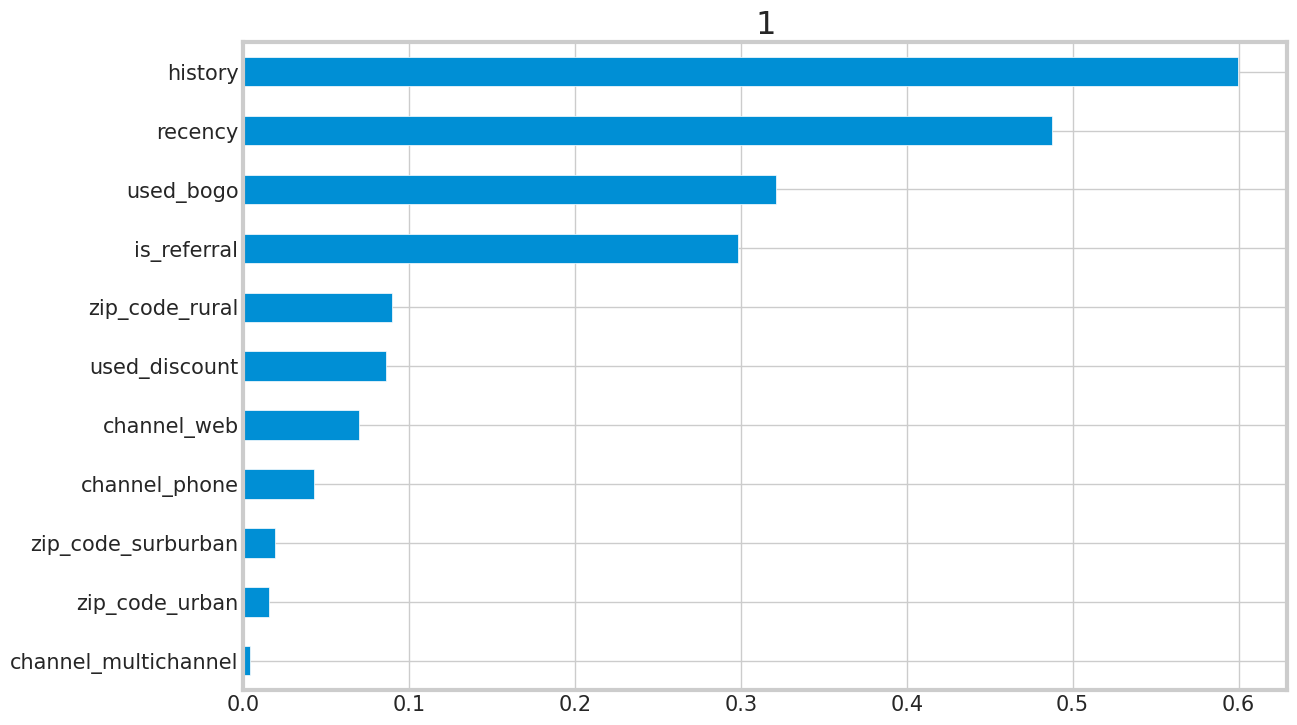

In [550]:
# Visualization
lg_tlearner.plot_importance(X=X, tau=lg_tlearner_ite, normalize=True, method='permutation', features=feature_names)

## T-Learner Model Interpretation

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

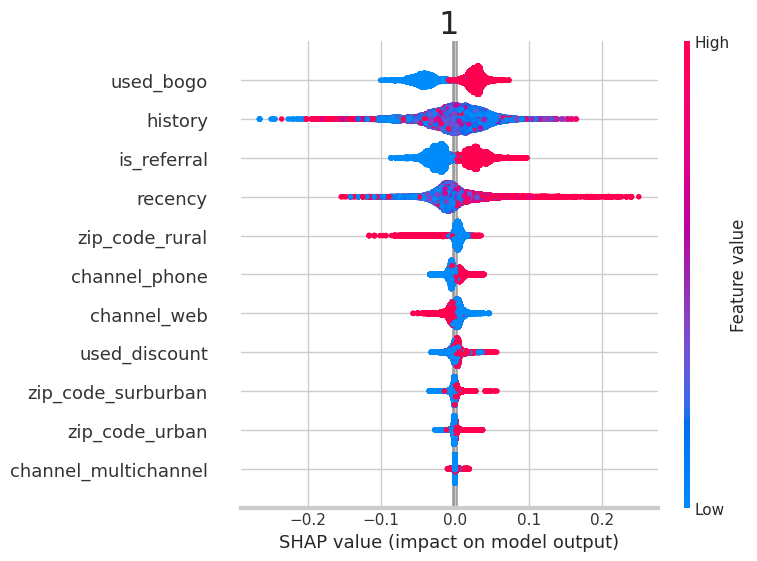

In [551]:
# Plot shap values
lg_tlearner.plot_shap_values(X=X, tau=lg_tlearner_ite, features=feature_names)

From the SHAP plot we can see that
- **used_bogo** is the most important feature, followed by **history**, **is_referral**, and **recency**.
- Higher value of **used_bogo** (customer used a buy one get one before) leads to higher chance of conversion. Lower value of **used_bogo** (customer has not used a buy one get one before) leads to lower chance of conversion.

In [552]:
df_preds = pd.DataFrame([lg_slearner_ite.ravel(),
                          lg_tlearner_ite.ravel(),
                          treatment.ravel(),
                          y.ravel()],
                       index=['S','T','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [553]:
df_result = pd.DataFrame([lg_slearner, lg_tlearner],
                     index=['S','T'], columns=['ATE'])
df_result['AUUC'] = auuc_score(df_preds)

In [554]:
df_result

,ATE,AUUC
S,BaseSClassifier(model=LGBMClassifier(random_st...,0.945620
T,BaseTClassifier(model_c=LGBMClassifier(random_...,1.364988


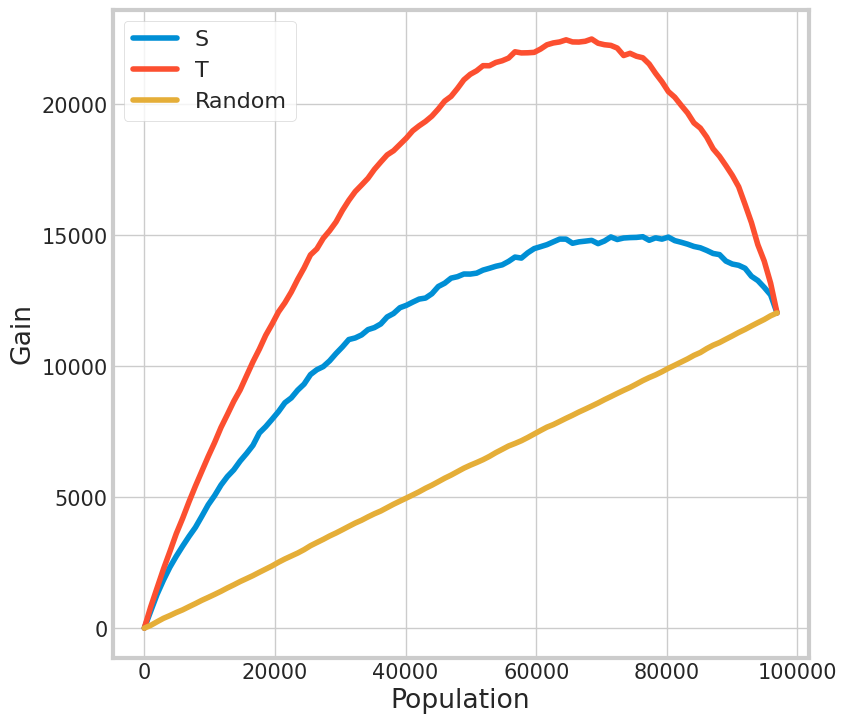

In [555]:
plot_gain(df_preds)

Thank You!